In [10]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Paths
output_dir = "./lfw_deepfunneled"
dataset_path = os.path.join(output_dir, 'lfw-deepfunneled')

# Function to load images and labels from the LFW dataset
def load_lfw_dataset(dataset_path):
    image_paths = []
    labels = []
    
    for label_folder in os.listdir(dataset_path):
        label_folder_path = os.path.join(dataset_path, label_folder)
        for img_filename in os.listdir(label_folder_path):
            img_path = os.path.join(label_folder_path, img_filename)
            image_paths.append(img_path)
            labels.append(label_folder)
    
    return image_paths, labels



In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Dropout, Flatten, BatchNormalization,Dot
from tensorflow.keras.models import Model
from keras_vggface.vggface import VGGFace
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
# Define the base model using ResNet50 from VGGFace
from tensorflow.keras import regularizers

# Contrastive loss function
def contrastive_loss(y_true, y_pred):
    margin = 1.0
    y_true = tf.cast(y_true, dtype='float32')
    squared_pred = K.square(y_pred)
    squared_margin = K.square(K.maximum(margin - y_pred, 0))
    loss = K.mean(y_true * squared_pred + (1 - y_true) * squared_margin)
    return loss
# Build the base model using VGGFace with ResNet50
def build_base_model():
    resnet = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3))
    for layer in resnet.layers[:-10]:  # Fine-tune the last 10 layers
        layer.trainable = False
    x = Flatten()(resnet.output)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)  # Embedding dimension is 128
    x = BatchNormalization()(x)
    x = Lambda(lambda t: K.l2_normalize(t, axis=1))(x)
    return Model(resnet.input, x)

# Create the Siamese Network for comparison
def build_siamese_network(input_shape):
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
    
    base_model = build_base_model()
    
    processed_a = base_model(input_a)
    processed_b = base_model(input_b)
    
    # Cosine similarity for comparison
    distance = Dot(axes=-1, normalize=True)([processed_a, processed_b])
    
    siamese_network = Model([input_a, input_b], distance)
    
    return siamese_network
base_model=build_base_model()
base_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

input_shape = (224, 224, 3)
siamese_network = build_siamese_network(input_shape)
siamese_network.compile(optimizer=Adam(learning_rate=1e-4), loss=contrastive_loss, metrics=['accuracy'])
siamese_network.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_3 (Functional)           (None, 128)          24678464    ['input_6[0][0]',                
                                                                  'input_7[0][0]']          

In [12]:
import os
import cv2
import numpy as np
import random
from collections import defaultdict

def load_filtered_lfw_dataset(dataset_dir):
    image_paths = []
    labels = []
    
    # Dictionary to store the number of images per label
    label_counts = defaultdict(int)
    
    # Traverse through the dataset and count images per label
    for label_folder in os.listdir(dataset_dir):
        label_folder_path = os.path.join(dataset_dir, label_folder)
        if os.path.isdir(label_folder_path):
            images = os.listdir(label_folder_path)
            if len(images) >= 2:  # Filter out labels with fewer than 2 images
                for img_filename in images:
                    img_path = os.path.join(label_folder_path, img_filename)
                    image_paths.append(img_path)
                    labels.append(label_folder)
                label_counts[label_folder] = len(images)
    
    return image_paths, labels

# Encode labels
def encode_labels(labels):
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    return labels_encoded, label_encoder

# Load the LFW dataset and filter labels
# Paths
output_dir = "./lfw_deepfunneled"
dataset_path = os.path.join(output_dir, 'lfw-deepfunneled')

lfw_image_paths, lfw_labels = load_filtered_lfw_dataset(dataset_path)
lfw_labels_encoded, _ = encode_labels(lfw_labels)


In [22]:
def preprocess_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image could not be loaded: {image_path}")
    img_resized = cv2.resize(img, target_size)
    img_normalized = img_resized.astype('float32') / 255.0
    return img_normalized

In [24]:
def pair_generator(image_paths, labels, batch_size=10):
    while True:
        pairs = []
        labels_pairs = []
        
        num_samples = len(image_paths)
        
        # Create a dictionary to group images by label
        label_to_images = defaultdict(list)
        for img_path, label in zip(image_paths, labels):
            label_to_images[label].append(img_path)
        
        # Convert keys to a list for random sampling
        label_keys = list(label_to_images.keys())
        
        # Generate pairs
        for _ in range(batch_size):
            # Select two different labels
            label1, label2 = random.sample(label_keys, 2)
            
            # Choose random images from each label
            img1 = random.choice(label_to_images[label1])
            img2 = random.choice(label_to_images[label2])
            
            # Create a positive pair
            if random.random() > 0.5:
                img2 = random.choice(label_to_images[label1])
                labels_pairs.append(1)
            else:
                labels_pairs.append(0)
                
            pairs.append([preprocess_image(img1), preprocess_image(img2)])
        
        yield np.array(pairs), np.array(labels_pairs)


In [26]:
gen = pair_generator(lfw_image_paths, lfw_labels, batch_size=10)
# Example: Process the first batch
pairs, pairs_labels = next(gen)
print(pairs.shape, pairs_labels.shape)
pairs_a = pairs[:, 0]
pairs_b = pairs[:, 1]

(10, 2, 224, 224, 3) (10,)


Epoch 1/100
1/1 [==============================] - 46s 46s/step - loss: 0.0783 - val_loss: 0.4998
Epoch 2/100
1/1 [==============================] - 3s 3s/step - loss: 0.0601 - val_loss: 0.4997
Epoch 3/100
1/1 [==============================] - 3s 3s/step - loss: 0.0327 - val_loss: 0.4997
Epoch 4/100
1/1 [==============================] - 3s 3s/step - loss: 0.0335 - val_loss: 0.4997
Epoch 5/100
1/1 [==============================] - 3s 3s/step - loss: 0.0380 - val_loss: 0.4997
Epoch 6/100
1/1 [==============================] - 3s 3s/step - loss: 0.0555 - val_loss: 0.4997
Epoch 7/100
1/1 [==============================] - 4s 4s/step - loss: 0.0434 - val_loss: 0.4997
Epoch 8/100
1/1 [==============================] - 3s 3s/step - loss: 0.0399 - val_loss: 0.4997
Epoch 9/100
1/1 [==============================] - 3s 3s/step - loss: 0.0277 - val_loss: 0.4997
Epoch 10/100
1/1 [==============================] - 3s 3s/step - loss: 0.0248 - val_loss: 0.4997
Epoch 11/100
1/1 [===================

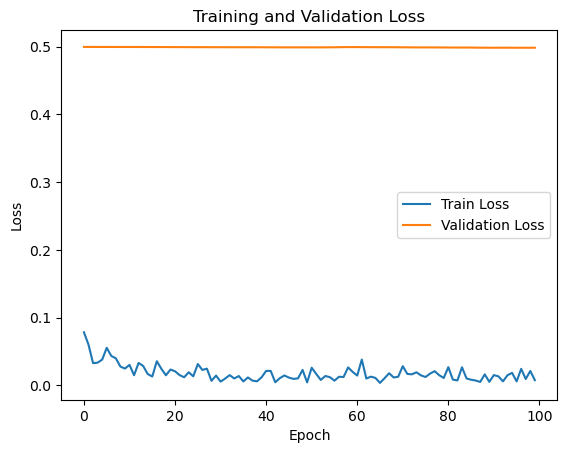

In [28]:
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
# Compile the model with a specific learning rate
optimizer = Adam(learning_rate=0.00005)  # Lower learning rate
siamese_network.compile(optimizer=optimizer, loss=contrastive_loss)
# Train the model with the learning rate scheduler
history = siamese_network.fit(
    [pairs_a, pairs_b], pairs_labels,
    epochs=100,
    validation_split=0.2,
    
)

import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()




In [30]:
# Load and preprocess new dataset
def load_new_dataset(dataset_dir):
    image_paths = []
    labels = []
    
    for label_folder in os.listdir(dataset_dir):
        label_folder_path = os.path.join(dataset_dir, label_folder)
        for img_filename in os.listdir(label_folder_path):
            img_path = os.path.join(label_folder_path, img_filename)
            image_paths.append(img_path)
            labels.append(label_folder)
    
    return image_paths, labels

new_image_paths, new_labels = load_new_dataset("dataset")


In [32]:
# Generate embeddings for the new dataset
base_model = build_base_model()

# Assuming new_image_paths and new_labels are already loaded and preprocessed
def generate_embeddings(image_paths, model):
    embeddings = []
    for img_path in image_paths:
        img = preprocess_image(img_path)
        embedding = model.predict(np.expand_dims(img, axis=0)).flatten()
        embeddings.append(embedding)
    return np.array(embeddings)

new_dataset_embeddings = generate_embeddings(new_image_paths, base_model)


1/1 [==============================] - 0s 263ms/step


In [36]:
# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(new_labels)
new_labels_encoded = label_encoder.transform(new_labels)


In [40]:
def preprocess_image(image, target_size=(224, 224)):
    if isinstance(image, str):  # If the input is a file path
        img = cv2.imread(image)
        if img is None:
            raise ValueError(f"Image could not be loaded: {image}")
    else:  # If the input is an image frame
        img = image
    
    img_resized = cv2.resize(img, target_size)
    img_normalized = img_resized.astype('float32') / 255.0
    return img_normalized


In [42]:
def generate_embedding_from_camera(base_model):
    # Capture an image from the camera
    cap = cv2.VideoCapture(0)
    ret, frame = cap.read()
    cap.release()
    
    if not ret:
        print("Error capturing image.")
        return None
    
    # Preprocess the image frame
    preprocessed_image = preprocess_image(frame)
    
    # Generate embedding
    embedding = base_model.predict(np.expand_dims(preprocessed_image, axis=0)).flatten()
    return embedding


In [48]:
def verify_face_real_time(base_model, new_dataset_embeddings, new_labels):
    captured_embedding = generate_embedding_from_camera(base_model)
    
    if captured_embedding is None:
        return
    
    # Compare captured embedding with stored embeddings
    distances = np.linalg.norm(new_dataset_embeddings - captured_embedding, axis=1)
    min_distance_index = np.argmin(distances)
    threshold=0.5
    if distances[min_distance_index] < threshold:
        print(f"Match found: {new_labels[min_distance_index]}")
    else:
        print("No match found.")
